In [1]:
from pathlib import Path
from collections import namedtuple
import math
import numpy as np
import pandas as pd
import scipy.stats as sstats
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle, Polygon
import sliding1d as sliding

import datareader as reader
import saccades

In [2]:
dataset_root = "../01_data/04_formatted"
figdir       = Path("../05_figures/saccades")
saved        = False

## Preparation of trials

- scaling whisker positions
- computing whisker asymmetry
- detect saccades

In [3]:
def get_info(trials):
    sessions = set((trial.subject, trial.session) for trial in trials)
    subjects = set(trial.subject for trial in trials)
    epochs   = sum(trial.states.shape[0] for trial in trials)
    return f"{len(trials)} trials out of {len(sessions)} sessions from {len(subjects)} subjects ({epochs} epochs)"

alltrials = reader.load_trials(dataset_root)
trials    = [trial for trial in alltrials if trial.has_eyedata()]

print("## Number of trials/epochs used for analysis\n")
print(f"- all annotated trials: {get_info(alltrials)}")
print(f"- trials with eye positions: {get_info(trials)}")

## Number of trials/epochs used for analysis

- all annotated trials: 113 trials out of 21 sessions from 4 subjects (876 epochs)
- trials with eye positions: 91 trials out of 17 sessions from 4 subjects (728 epochs)


In [4]:
def normalize(vec, subtract_min=True):
    m = np.nanmin(vec)
    M = np.nanmax(vec)
    den = vec - m if subtract_min == True else vec
    return den / (M - m)

In [5]:
for trial in trials:
    for side in ("left", "right"):
        trial.tracking[f"{side}_whisker_normalized"] = normalize(trial.tracking[f"{side}_whisker_angle_deg"], subtract_min=False)
    trial.tracking['leftward_whisker_asymmetry'] = trial.tracking.right_whisker_normalized - trial.tracking.left_whisker_normalized
    trial.tracking['rightward_whisker_asymmetry'] = trial.tracking.left_whisker_normalized - trial.tracking.right_whisker_normalized
    trial.tracking["saccades"] = saccades.detect(trial.tracking.time,
                                                 trial.tracking.left_pupil_normalized_position,
                                                 trial.tracking.right_pupil_normalized_position)
        
trials[0].tracking.head()

time  left_whisker_angle_deg  left_whisker_radius_px  \
0  0.000                3.513870              271.151556   
1  0.005                4.533231              272.785300   
2  0.010                5.875672              273.417605   
3  0.015                6.574637              271.189545   
4  0.020                6.493624              271.002909   

   left_pupil_normalized_position  left_pupil_normalized_diameter  \
0                        0.048674                        0.086702   
1                        0.048674                        0.086702   
2                        0.048674                        0.086702   
3                        0.048674                        0.086702   
4                        0.048674                        0.086702   

   right_whisker_angle_deg  right_whisker_radius_px  \
0                13.644373               243.731827   
1                14.096692               247.667480   
2                15.003054               248.133120   
3                15.494432               246.543158   
4                15.364230               246.802274   

   right_pupil_normalized_position  right_pupil_normalized_diameter  \
0                         0.056916                         0.097801   
1                         0.056916                         0.097801   
2                         0.056916                         0.097801   
3                         0.056916                         0.097801   
4                         0.056916                         0.097801   

   left_whisker_normalized  right_whisker_normalized  \
0                 0.026068                  0.093315   
1                 0.033631                  0.096408   
2                 0.043590                  0.102607   
3                 0.048775                  0.105968   
4                 0.048174                  0.105077   

   leftward_whisker_asymmetry  rightward_whisker_asymmetry  saccades  
0                    0.067246                    -0.067246       0.0  
1                    0.062778                    -0.062778       0.0  
2                    0.059017                    -0.059017       0.0  
3                    0.057192                    -0.057192       0.0  
4                    0.056903                    -0.056903       0.0

## Extracting whisker asymmetry around saccades

In [6]:
def extract_traces_around_saccades(trials,
                                   pattern,
                                   trace,
                                   detect='left',
                                   threshold=1e-3,
                                   window_radius=500,
                                   baseline_radius=10,
                                   shuffle=None):
    """returns a list of 'epochs', with each epoch being dict consisting of keys:
    
    session:  tuple of (subject, date)
    baseline: a float value (peri-saccade median)
    trace:    a np.ndarray of size (window_radius * 2) + 1 (peri-saccade trace)
    """
    pattern         = str(pattern)
    trace           = str(trace)
    detect          = str(detect).lower()
    threshold       = abs(threshold)
    window_radius   = int(window_radius)
    baseline_radius = int(baseline_radius)
    
    if shuffle is not None:
        np.random.seed(shuffle)
    
    if detect == 'left':
        matcher = lambda val: val > threshold
    elif detect == 'right':
        matcher = lambda val: val < -threshold
    elif detect == 'both':
        matcher = lambda val: np.abs(val) > threshold
    else:
        raise ValueError(detect)

    epochs = []

    for i, trial in enumerate(trials):
        # detect epochs that match the given pattern
        valid = np.zeros(trial.tracking.shape[0], dtype=bool)
        for start, stop in trial.get_timeranges(pattern):
            valid[start-1:stop] = True
        if np.count_nonzero(valid) == 0:
            continue
        
        # detect saccade events
        sacc  = matcher(np.array(trial.tracking.saccades.values, copy=False))
        if shuffle is not None:
            extract = sacc[valid]
            np.random.shuffle(extract)
            sacc[valid] = extract
        evts  = np.where(np.logical_and(valid, sacc))[0]

        # extract time windows around events
        for evt in evts:
            if evt < window_radius:
                continue
            window = trial.tracking[trace][(evt-window_radius):(evt+window_radius+1)]
            base   = np.nanmedian(trial.tracking[trace][(evt-baseline_radius):(evt+baseline_radius+1)])
            epochs.append(dict(session=(trial.subject, trial.session), 
                               trial_id=i,
                               baseline=base,
                               trace=window))
    return epochs

In [7]:
pat    = '<Backward>'
attr   = '{toward}ward_whisker_asymmetry'
radius = 120 # in samples -- 600 ms at 200 Hz

epochs = {}
for toward, side in (('left', 'right'), ('right', 'left')):
    _epochs = {}
    
    # true traces
    _epochs['data'] = extract_traces_around_saccades(trials,
                                                     pattern=pat,
                                                     trace=attr.format(toward=toward),
                                                     detect=toward,
                                                     window_radius=radius)
    
    # traces using shuffled saccade timings
    _epochs['rand'] = extract_traces_around_saccades(trials,
                                                     pattern=pat,
                                                     trace=attr.format(toward=toward),
                                                     detect=toward,
                                                     window_radius=radius,
                                                     shuffle=539167)
    _epochs['N'] = len(_epochs['data'])
    n_traces = _epochs['N']
    n_trials = len(set(epoch['trial_id'] for epoch in _epochs['data']))
    n_sessions = len(set(epoch['session'] for epoch in _epochs['data']))
    n_animals  = len(set(epoch['session'][0] for epoch in _epochs['data']))
    epochs[toward] = _epochs
    print(f"{toward}ward: {n_traces} traces / {n_trials} trials / {n_sessions} sessions / {n_animals} animals")

# data merged
dmerged = np.stack([epoch['trace'] for epoch in epochs['left']['data']] + \
                   [epoch['trace'] for epoch in epochs['right']['data']], axis=-1)

# shuffled merged
rmerged = np.stack([epoch['trace'] for epoch in epochs['left']['rand']] + \
                   [epoch['trace'] for epoch in epochs['right']['rand']], axis=-1)

leftward: 120 traces / 63 trials / 16 sessions / 4 animals
rightward: 94 traces / 51 trials / 16 sessions / 4 animals


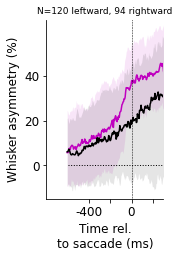

In [8]:
fig = plt.figure(figsize=(2.5, 3.5))
for lab, val, col in (('Data', dmerged, 'm'), ('Shuffle', rmerged, 'k')):
    m = np.median(val, axis=-1)
    l = np.percentile(val, 25, axis=-1)
    u = np.percentile(val, 75, axis=-1)
    x = (np.arange(m.size) - (m.size // 2 + 1))*5
    plt.plot(x, m, '-', c=col, lw=1.5, label=lab)
    plt.fill_between(x, l, u, color=col, alpha=.1, lw=0)
plt.vlines(0, -1, 1, color='k', linewidth=.5, linestyle='dashed')
plt.hlines(0, -600, 600, color='k', linewidth=1, linestyle='dotted')
plt.title(f"N={epochs['left']['N']} leftward, {epochs['right']['N']} rightward", fontsize=9)
plt.xlim(-800, 300)
plt.ylim(-0.15, 0.65)
plt.xticks((-400, -200, 0, 200), ("-400", "", "0", ""))
plt.yticks((0, .2, .4), ("0", "20", "40"))
plt.xlabel("Time rel.\nto saccade (ms)", fontsize=12)
plt.ylabel("Whisker asymmetry (%)", fontsize=12)
plt.tick_params(labelsize=12)
# plt.legend(fontsize=12, frameon=False, loc='upper right')
for side in ("top", "right"):
    plt.gca().spines[side].set_visible(False)
plt.subplots_adjust(left=.3, bottom=.22, top=.93, right=.95)

if saved == True:
    figpath = figdir / "saccade_traces.png"
    if not figdir.exists():
        figdir.mkdir(parents=True)
    fig.savefig(str(figpath), dpi=300)
plt.show()

In [9]:
class BoxSummary(namedtuple('_BoxSummary', ('n', 'q1', 'q2', 'q3', 'min', 'max', 'outliers'))):
    @classmethod
    def from_values(cls, values):
        values = values[~np.isnan(values)]
        n  = values.size
        q1 = np.percentile(values, 25)
        q2 = np.median(values)
        q3 = np.percentile(values, 75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        vmin  = values[values >= lower].min()
        vmax  = values[values <= upper].max()
        outliers = values[np.logical_or(values < vmin, values > vmax)]
        return cls(n, q1, q2, q3, vmin, vmax, outliers)

def plot_box_around(x, boxsummary, ax=None, color='gray', mcolor='w', ecolor='k', ocolor='k',
                    boxwidth=.5, mlinewidth=1.5, elinewidth=1, marker='o', markersize=2, boxalpha=.6):
    v = boxsummary
    if ax is None:
        ax = plt.gca()
    ax.add_patch(Rectangle((x-boxwidth/2,v.q1), boxwidth, v.q3-v.q1, color=color, linewidth=0, alpha=boxalpha))
    ax.hlines(v.q2, x-boxwidth*.45, x+boxwidth*.45, color=mcolor, linewidth=mlinewidth)
    ax.vlines(x, v.min, v.q1, color=ecolor, linewidth=elinewidth)
    ax.vlines(x, v.q3, v.max, color=ecolor, linewidth=elinewidth)
    if v.outliers.size > 0:
        ax.plot((x,)*v.outliers.size, v.outliers, marker, color=ocolor, markersize=markersize)

In [10]:
def plabel(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return "NS"

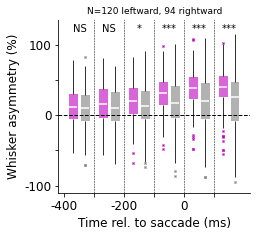

Group                               Data                      \
            Range Left Right             P   IQR_min        Q1        Q2   
0  -400 – -300 ms  120    94  2.788900e-01 -0.530916 -0.049302  0.122488   
1  -300 – -200 ms  120    94  1.243208e-01 -0.560208 -0.033921  0.157350   
2  -200 – -100 ms  120    94  4.421350e-02 -0.402024  0.020761  0.200468   
3  -100 –   +0 ms  120    94  9.214959e-06 -0.311936  0.138647  0.311517   
4    +0 – +100 ms  120    94  5.216176e-08 -0.168744  0.236523  0.386047   
5  +100 – +200 ms  120    94  1.409669e-06 -0.183012  0.255620  0.403190   

                                                                          \
         Q3   IQR_max                                           Outliers   
0  0.305917  0.778465                                                 []   
1  0.372399  0.811325                                                 []   
2  0.379275  0.829799                                  [-0.6771,-0.5341]   
3  0.474135  0.908852                           [-0.4840,-0.4222,0.9837]   
4  0.542240  0.919303  [-0.4836,-0.4795,-0.3390,-0.3100,-0.2868,1.061...   
5  0.557878  1.011172  [-0.5468,-0.4975,-0.4861,-0.3602,-0.3033,-0.29...   

    Shuffle                                                                    
    IQR_min        Q1        Q2        Q3   IQR_max                  Outliers  
0 -0.561890 -0.077181  0.104867  0.281417  0.698002  [-0.7038,-0.7033,0.8216]  
1 -0.693004 -0.084541  0.106382  0.330992  0.693507                        []  
2 -0.658452 -0.057155  0.133607  0.347231  0.913788         [-0.7372,-0.6775]  
3 -0.681709 -0.041069  0.179910  0.409911  1.011172         [-0.8646,-0.7956]  
4 -0.738590 -0.053044  0.201686  0.456445  1.093199         [-0.8822,-0.8696]  
5 -0.868905 -0.076679  0.262897  0.477193  1.149776                 [-0.9441]

In [11]:
grouping = [
    ('-400 – -300 ms', slice(40, 60)),
    ('-300 – -200 ms', slice(60, 80)),
    ('-200 – -100 ms', slice(80, 100)),
    ('-100 –   +0 ms', slice(100, 120)),
    ('  +0 – +100 ms', slice(120, 140)),
    ('+100 – +200 ms', slice(140, 160))
]

fig = plt.figure(figsize=(3.5, 3))
ax  = plt.gca()
sep = np.arange(1, len(grouping)) - 0.5

tab = {
    ('Group', 'Range'): [],
    ('Group', 'Left'): [],
    ('Group', 'Right'): [],
    ('Group', 'P'): [],
    ('Data', 'IQR_min'): [],
    ('Data', 'Q1'): [],
    ('Data', 'Q2'): [],
    ('Data', 'Q3'): [],
    ('Data', 'IQR_max'): [],
    ('Data', 'Outliers'): [],
    ('Shuffle', 'IQR_min'): [],
    ('Shuffle', 'Q1'): [],
    ('Shuffle', 'Q2'): [],
    ('Shuffle', 'Q3'): [],
    ('Shuffle', 'IQR_max'): [],
    ('Shuffle', 'Outliers'): [],
}

for base, (group_name, rng) in enumerate(grouping):
    baseoffset = base
    tab['Group', 'Range'].append(group_name)
    tab['Group', 'Left'].append(epochs['left']['N'])
    tab['Group', 'Right'].append(epochs['right']['N'])
    
    _data = np.median(dmerged[rng], axis=0)
    _rand = np.median(rmerged[rng], axis=0)
    for shift, lab, vals, col in ((-1, 'Data',    _data, 'm'),
                                  (1,  'Shuffle', _rand, 'gray')):
        box = BoxSummary.from_values(vals)
        plot_box_around(baseoffset + 0.2*shift, box, marker='x', color=col, ocolor=col, boxwidth=.3, elinewidth=.8)
        tab[lab, 'Q1'].append(box.q1)
        tab[lab, 'Q2'].append(box.q2)
        tab[lab, 'Q3'].append(box.q3)
        tab[lab, 'IQR_min'].append(box.min)
        tab[lab, 'IQR_max'].append(box.max)
        tab[lab, 'Outliers'].append('[' + ','.join(f"{v:.4f}" for v in sorted(box.outliers)) + ']')
        
    p = sstats.mannwhitneyu(_data, _rand).pvalue
    plt.text(baseoffset, 1.15, plabel(p), fontsize=10, ha='center', va='bottom')
    tab['Group', 'P'].append(p)

plt.vlines(sep, -2, 2, color='k', linewidth=.5, linestyle='dashed')
plt.hlines(0, -0.7, 6.7, color='k', linewidth=1, linestyle='dashed')
plt.xlim(-0.7, 5.7)
plt.ylim(-1.1, 1.35)
plt.xticks((-0.5, 0.5, 1.5, 2.5, 3.5, 4.5), ("-400", "", "-200", "", "0", ""))
plt.yticks((-1, -0.5, 0, 0.5, 1), ("-100",  "", "0", "", "100",))
plt.xlabel("Time rel. to saccade (ms)", fontsize=12)
plt.ylabel("Whisker asymmetry (%)", fontsize=12)
plt.title(f"N={epochs['left']['N']} leftward, {epochs['right']['N']} rightward", fontsize=9)
for side in ("top", "right"):
    ax.spines[side].set_visible(False)
ax.tick_params(labelsize=12)
plt.subplots_adjust(left=.22, right=.98, bottom=.18, top=.98)
if saved == True:
    figpath = figdir / "saccade_binned.png"
    if not figdir.exists():
        figdir.mkdir(parents=True)
    fig.savefig(str(figpath), dpi=300)
plt.show()

tab = pd.DataFrame(data=tab)
if saved == True:
    tabpath = figdir / "saccade_binned.csv"
    tab.to_csv(str(tabpath), header=True, index=False)
tab